In [1]:
import caustics
from caustics import Module, forward, Param
from torch.nn.functional import conv2d, avg_pool2d
import numpy as np
import torch
import matplotlib.pyplot as plt

# Building your own simulator from scratch: a tutorial

In this tutorial, we will build a fully-functional gravitational lensing simulator based on LensSource, the prebuilt simulator which comes with Caustics. We will then demonstrate how you can modify a custom simulator to extend its capabilities. 

### Part 1: The `__init__` function

First, we begin by creating a new **class** for our simulator. 
**For those new to object-oriented programming**: a class consists of a recipe for building an object. An object is a reusable container which contains functions and their parameters. Objects are also referred to as **instances** of a class, and the parameters which are assigned to a class are called **instance variables**. 

We want our simulator to inherit from the **Module** class in Caustics, which is a basic framework for constructing simulator objects. To create inheritance, we put the parent class as an argument (in parentheses) to the child class. In the `__init__` function, we need a few basic ingredients to create the simulator:
1. A lens mass distribution
2. A model for the lens light
3. A model for the source light
4. A model for the telescope PSF
5. A value for the pixel scale of the CCD
6. The number of pixels in the CCD
7. The upsample factor (increases the resolution of the simulator internally to improve accuracy)
8. The redshift of the source light (item 3)

We can also provide a name for the simulator.

Within our `__init__` function, we need to provide instructions to construct the basic structure of the simulator object, which is done by calling the `__init__` function of the `super` class, which in this case is `Module` from Caustics.

Within `__init__` we also need to construct the components of our simulator. For components which are constructed once (lens mass model, lens light model, and source light model), we simply need to make them instance variables of the current object being constructed (`self`). We do the same for parameters whose value we wish to only set once, such as the coordinate grid, which we generate with the `meshgrid` function of caustics. For parameters which we wish to sample with our MCMC (which are not already parameters of any of the existing components), we need to register them as a `Param` object, which will allow our simulator to find them in the flattened vector of parameters which we will pass to the simulator. In this example, we register the PSF as a `Param` and name it `"PSF"`. We also have to tell Param what shape the PSF array will take so that the PSF can be extracted from the flattened tensor (in this example, we allow a variable-sized PSF). For more information on the underlying functionality of `Module`, `Param`, and related parameter handling capabilities in Caustics, see the underlying **caskade** package and associated documentation: https://caskade.readthedocs.io/en/latest/notebooks/BeginnersGuide.html

In [2]:
class Singlelens(Module):
    def __init__(
        self,
        lens,
        lens_light,
        source,
        pixelscale,
        pixels_x,
        upsample_factor,
        n_psf,
        psf=None,  # Since we want PSF to be a Param, its value will be set at inference time alognside all the other Params
        name: str = "sim",
    ):
        super().__init__(name)

        self.lens = lens
        self.src = source
        self.n_psf = n_psf
        self.lens_light = lens_light
        self.psf = Param("PSF", psf, shape=(self.n_psf, self.n_psf))
        self.upsample_factor = upsample_factor

        # Create the high-resolution grid
        thx, thy = caustics.utils.meshgrid(
            pixelscale / upsample_factor,
            upsample_factor * pixels_x,
            dtype=torch.float32,
        )

        self.thx = thx
        self.thy = thy

    @forward
    def run_simulator(self, psf):
        # Ray-trace to get the lensed positions
        bx, by = self.lens.raytrace(self.thx, self.thy)

        # Evaluate the lensed source brightness at high resolution
        image = self.src.brightness(bx, by)

        # Add the lens light
        image += self.lens_light.brightness(self.thx, self.thy)

        # Downsample to the desired resolution
        image_ds = avg_pool2d(image[None, None], self.upsample_factor)[0, 0]

        # Convolve with the PSF using conv2d
        psf_normalized = (psf.T / psf.sum())[None, None]
        image_ds = (
            conv2d(image_ds[None, None], psf_normalized, padding="same")
            .squeeze(0)
            .squeeze(0)
        )

        return image_ds

### Part 2: the `@forward`-decorated function

In the code above, in addition to the `__init__` function, you can see that we have added another function called `run_simulator`. This is the part of our simulator object which will actually perform the simulation (when called). Our simulation has a few basic steps:

1. Raytrace the coordinate grid backwards from the lens plane (thx, thy) to the source plane using the lens mass distribution. This produces bx and by, whose values are the source plane coordinates at the corresponding locations in the lens plane.
2. Evaluate the brightness of the source light model at the raytraced coordinates (which creates the gravitationally lensed image)
3. Add lens light to the image
4. Downsample the image to the correct pixel scale
5. Convolve with the PSF of the telescope

To ensure that all the Param parameters in the simulator are handled correctly, we need to add the `@forward` decorator from `Caustics` (which wraps the `@forward` decorator in `caskade`) to our `run_simulator` function. We also need to pass arguments to the `run_simulator` function for any `Param` objects which we defined in the `__init__` (in this case, `PSF` is passed as an argument).

### Part 3: Instantiating our simulator

Now that we have completed our custom simulator, we need to **instantiate** the components of the simulator and the simulator itself. The instantiation process creates an object in memory from a class. 

In [3]:
# Cosmology model
cosmology = caustics.FlatLambdaCDM(name="cosmo")
# Source light model
source_light = caustics.Sersic(name="sourcelight")
# Lens mass model
epl = caustics.EPL(name="epl", cosmology=cosmology, z_s=3.5)
# Lens Light model
lens_light = caustics.Sersic(name="lenslight1")
# PSF and image resolution
pixscale = 0.11 / 2
fwhm = 0.269  # full width at half maximum of PSF
psf_sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
n_psf = 11
psf_image = caustics.utils.gaussian(
    nx=n_psf,
    ny=n_psf,
    pixelscale=pixscale,
    sigma=psf_sigma,
    upsample=1,
)
# Instantiate simulator
simulator = Singlelens(
    lens=epl,
    lens_light=lens_light,
    source=source_light,
    pixels_x=60 * 2,
    pixelscale=pixscale,
    upsample_factor=5,
    n_psf=n_psf,
)

Now that we have instantiated our simulator, we can visualize its structure using graphviz. The grayed out squares are parameters which are fixed (known as **static parameters** in Caustics), while the white squares are parameters whose value will be set once the `forward` function is run (these are known as **dynamic parameters** in Caustics). The arrows indicate which object contains which component. 

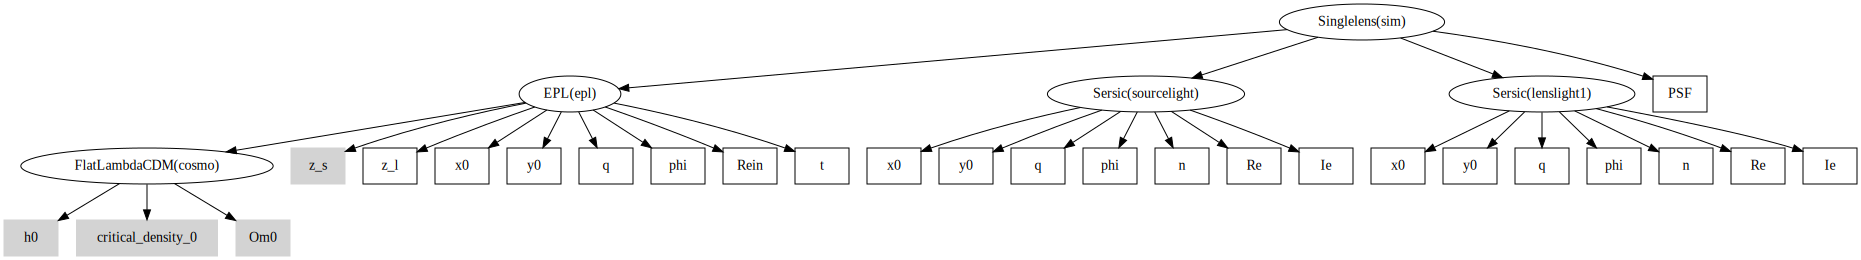

In [4]:
simulator.graphviz()

### Part 4: Passing parameters to our simulator

Now that we have designed our simulator class and instantiated our simulator object, we can use the `forward` method to run the simulator. Thanks to `caskade`, we can pass all of the dynamic parameters at once as a flattened Pytorch tensor. However, we need to know what order to put our parameters in the tensor. We can find the order by literally printing our simulator:

In [5]:
print(simulator)

sim|module
    epl|module
        cosmo|module
            h0|static
            critical_density_0|static
            Om0|static
        z_s|static
        z_l|dynamic
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        Rein|dynamic
        t|dynamic
    sourcelight|module
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        n|dynamic
        Re|dynamic
        Ie|dynamic
    lenslight1|module
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        n|dynamic
        Re|dynamic
        Ie|dynamic
    PSF|dynamic


In [6]:
params_for_simulator = torch.tensor(
    [
        # Lens redshift and mass
        1.5,  # z_l
        0.25,  # epl x0
        0.3,  # epl y0
        1 / 1.14,  # epl q
        np.pi / 2 + 1.6755160819145565,  # epl phi
        0.97,  # epl b
        1.04,  # epl t
        # Source light
        0.25,  # x0
        0.3,  # y0
        1 - 0.29,  # q
        -30 / 180 * torch.pi,  # phi
        4,  # n
        0.1,  # Re
        36,  # Ie
        # Lens light
        0.25,  # x0
        0.3,  # y0
        1 - 0.29,  # q
        -30 / 180 * torch.pi,  # phi
        4,  # n
        0.1,  # Re
        100,  # Ie
    ]
)
# Now add PSF to flattened tensor
params_for_simulator = torch.cat((params_for_simulator, psf_image.flatten()))

In [7]:
params_for_simulator.shape

torch.Size([142])

Each of the pixel values in the PSF is now an independent parameter which can be jointly sampled alongside the other parameters! Because we gave Param the expected shape of the PSF (n_psf, n_psf), Param will correctly extract it from the flattened tensor and reshape it to the right shape.

Now we can run our simulator by passing the flat parameter tensor to the `forward` function:

In [8]:
lensed_image = simulator.run_simulator(params_for_simulator)

We can then view the lensed image output by our simulator (here we have created an "Einstein cross"):

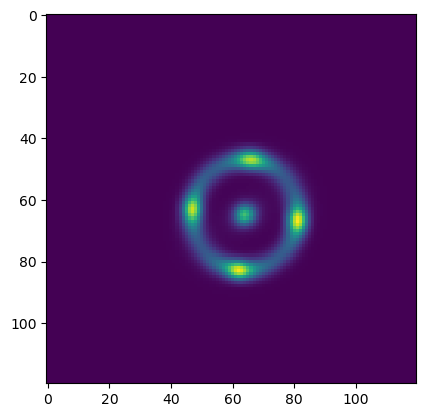

In [9]:
plt.imshow(lensed_image)
plt.show()

### Part 5: Customizing your simulator

So far, we have focused on re-creating the LensSource simulator provided by default in Caustics, but the real power of the Caustics package is reflected by its extensibility. 

Suppose we want to have a single background light source and a single lens mass distribution, but instead of a single lens light source, we want two lens light sources (this could be a modeling choice for merging lensed galaxies).

We can implement this by creating a new simulator class, which we will call `Doublelenslight`. This class is identical to `Singlelens`, except for two things: we add an extra `lens_light` to our `__init__`, and in the `forward` we add the second `lens_light` to the image.

In [10]:
class Doublelenslight(Module):
    def __init__(
        self,
        lens,
        lens_light1,
        lens_light2,  # NEW!
        source,
        pixelscale,
        pixels_x,
        upsample_factor,
        n_psf,
        psf=None,
        name: str = "sim",
    ):
        super().__init__(name)

        self.lens = lens
        self.src = source
        self.n_psf = n_psf
        self.lens_light1 = lens_light1
        self.lens_light2 = lens_light2  # NEW!
        self.psf = Param("PSF", psf, shape=(self.n_psf, self.n_psf))
        self.upsample_factor = upsample_factor

        # Create the high-resolution grid
        thx, thy = caustics.utils.meshgrid(
            pixelscale / upsample_factor,
            upsample_factor * pixels_x,
            dtype=torch.float32,
        )

        self.thx = thx
        self.thy = thy

    @forward
    def run_simulator(self, psf):
        # Ray-trace to get the lensed positions
        bx, by = self.lens.raytrace(self.thx, self.thy)

        # Evaluate the lensed source brightness at high resolution
        image = self.src.brightness(bx, by)

        # Add the lens light
        image += self.lens_light1.brightness(self.thx, self.thy)
        image += self.lens_light2.brightness(self.thx, self.thy)  # NEW!

        # Downsample to the desired resolution
        image_ds = avg_pool2d(image[None, None], self.upsample_factor)[0, 0]

        # Convolve with the PSF using conv2d
        psf_normalized = (psf.T / psf.sum())[None, None]
        image_ds = (
            conv2d(image_ds[None, None], psf_normalized, padding="same")
            .squeeze(0)
            .squeeze(0)
        )

        return image_ds

In [11]:
# Cosmology model
cosmology = caustics.FlatLambdaCDM(name="cosmo")
# Source light model
source_light = caustics.Sersic(name="sourcelight")
# Lens mass model
epl = caustics.EPL(name="epl", cosmology=cosmology, z_s=3.5)
# Lens Light models
lens_light1 = caustics.Sersic(name="lenslight1")
lens_light2 = caustics.Sersic(name="lenslight2")
# PSF and image resolution
pixscale = 0.11 / 2
fwhm = 0.269  # full width at half maximum of PSF
psf_sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
n_psf = 11
psf_image = caustics.utils.gaussian(
    nx=n_psf,
    ny=n_psf,
    pixelscale=pixscale,
    sigma=psf_sigma,
    upsample=1,
)
# Instantiate simulator
simulator = Doublelenslight(
    lens=epl,
    lens_light1=lens_light1,
    lens_light2=lens_light2,
    source=source_light,
    pixels_x=60 * 2,
    pixelscale=pixscale,
    upsample_factor=5,
    n_psf=n_psf,
)

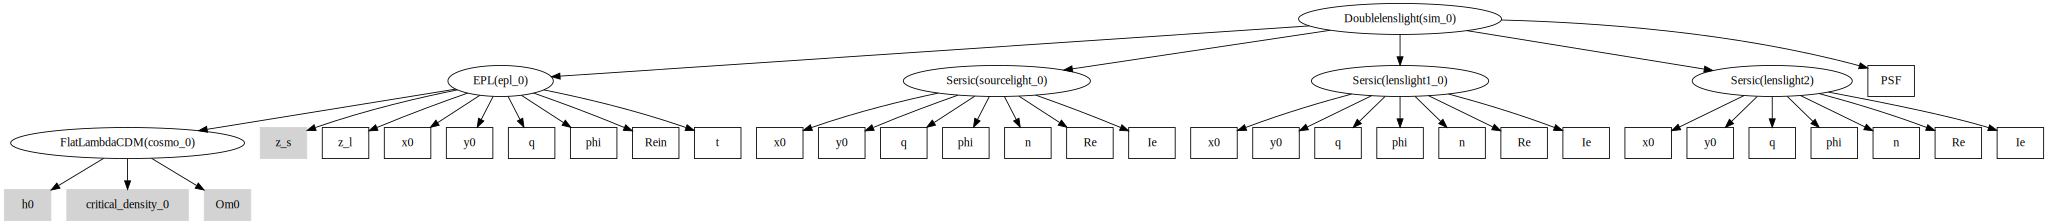

In [12]:
simulator.graphviz()

When passing parameters to the `forward`, we need to use 

In [13]:
print(simulator)

sim_0|module
    epl_0|module
        cosmo_0|module
            h0|static
            critical_density_0|static
            Om0|static
        z_s|static
        z_l|dynamic
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        Rein|dynamic
        t|dynamic
    sourcelight_0|module
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        n|dynamic
        Re|dynamic
        Ie|dynamic
    lenslight1_0|module
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        n|dynamic
        Re|dynamic
        Ie|dynamic
    lenslight2|module
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        n|dynamic
        Re|dynamic
        Ie|dynamic
    PSF|dynamic


In [14]:
params_for_simulator = torch.tensor(
    [
        # Lens redshift and mass
        1.5,  # z_l
        0.25,  # epl x0
        0.3,  # epl y0
        1 / 1.14,  # epl q
        np.pi / 2 + 1.6755160819145565,  # epl phi
        0.97,  # epl b
        1.04,  # epl t
        # Source light
        0.25,  # x0
        0.3,  # y0
        1 - 0.29,  # q
        -30 / 180 * torch.pi,  # phi
        4,  # n
        0.1,  # Re
        36,  # Ie
        # Lens light
        0.25,  # x0
        0.1,  # y0
        1 - 0.29,  # q
        -30 / 180 * torch.pi,  # phi
        4,  # n
        0.1,  # Re
        100,  # Ie
        # Lens light
        0.25,  # x0
        0.6,  # y0
        1 - 0.29,  # q
        -30 / 180 * torch.pi,  # phi
        4,  # n
        0.1,  # Re
        100,  # Ie
    ]
)
# Now add PSF to flattened tensor
params_for_simulator = torch.cat((params_for_simulator, psf_image.flatten()))

In [15]:
lensed_image = simulator.run_simulator(params_for_simulator)

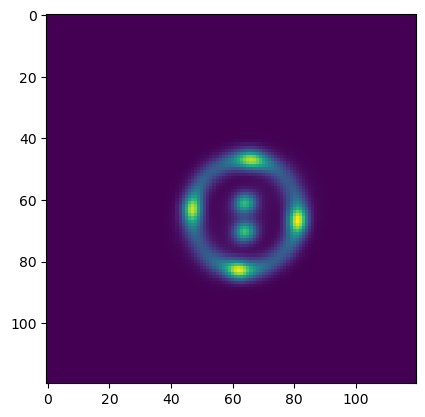

In [16]:
plt.imshow(lensed_image)
plt.show()